In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from distutils.dir_util import copy_tree, remove_tree

root_dir = "./"
train_dir = r"C:\Users\lenovo\OneDrive\Desktop\pga24\Capstone2\Alzheimer_s Dataset\train"
test_dir = r"C:\Users\lenovo\OneDrive\Desktop\pga24\Capstone2\Alzheimer_s Dataset\test"
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [8]:
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from keras.utils import plot_model
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers.experimental import SGD, Adam
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

In [9]:
WORK_DIR = './dataset/'
CLASSES = [ 'NonDemented','VeryMildDemented', 'MildDemented', 'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [10]:
imageGenerator = ImageDataGenerator(
        rescale = 1./255, 
        brightness_range= BRIGHT_RANGE, 
    
        zoom_range=ZOOM, 
        data_format=DATA_FORMAT, 
    
        fill_mode=FILL_MODE, 
        horizontal_flip=HORZ_FLIP
)

data_gen = imageGenerator.flow_from_directory(
    directory=WORK_DIR, 
    target_size=DIM,
    
    batch_size=6500, 
    shuffle=False
)

Found 6400 images belonging to 4 classes.


In [11]:
data, data_labels = data_gen.next()
print(data.shape, data_labels.shape)

(6400, 176, 176, 3) (6400, 4)


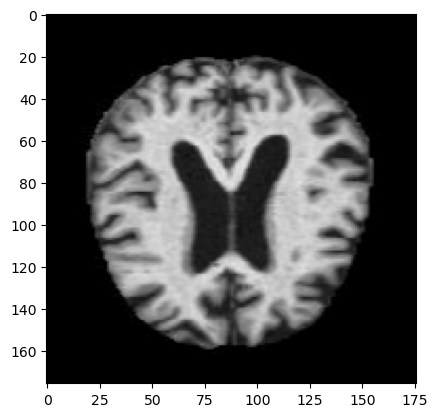

Label :  NonDemented


In [12]:
plt.imshow(data[0])
plt.show()
print("Label : ", CLASSES[np.where(data_labels[0] == 1)[0][0]])

In [13]:
sm = SMOTE(random_state=42)

data, data_labels = sm.fit_resample(data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), data_labels)

data = data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(data.shape, data_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(data, data_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels, val_labels = train_test_split(data, data_labels, test_size = 0.2, random_state=42)

## Model

### Neural Network Block

In [15]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [16]:
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [23]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.85:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [24]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        
        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        Dropout(0.2),
        conv_block(256),
        
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], 
    name = "cnn_model"
)

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
#     tf.keras.metrics.AUC(name='auc'), 
    tfa.metrics.F1Score(num_classes=4)
]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS
)

# model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='CNN_horizontal.png', rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
EPOCHS = 100

history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels), 
    callbacks=CALLBACKS, 
    epochs=EPOCHS
)

Epoch 1/100
320/320 [==============================] - 533s 2s/step - loss: 1.5196 - acc: 0.3560 - f1_score: 0.3539 - val_loss: 2.7558 - val_acc: 0.3055 - val_f1_score: 0.2166
Epoch 2/100
320/320 [==============================] - 446s 1s/step - loss: 0.8905 - acc: 0.5948 - f1_score: 0.5867 - val_loss: 3.3948 - val_acc: 0.2652 - val_f1_score: 0.1185
Epoch 3/100
320/320 [==============================] - 422s 1s/step - loss: 0.7226 - acc: 0.6666 - f1_score: 0.6619 - val_loss: 1.8232 - val_acc: 0.2937 - val_f1_score: 0.1900
Epoch 4/100
320/320 [==============================] - 425s 1s/step - loss: 0.6620 - acc: 0.6935 - f1_score: 0.6904 - val_loss: 0.7109 - val_acc: 0.6672 - val_f1_score: 0.6628
Epoch 5/100
320/320 [==============================] - 428s 1s/step - loss: 0.6167 - acc: 0.7223 - f1_score: 0.7214 - val_loss: 3.0772 - val_acc: 0.2824 - val_f1_score: 0.1500
Epoch 6/100
320/320 [==============================] - 428s 1s/step - loss: 0.5600 - acc: 0.7505 - f1_score: 0.7501 - va

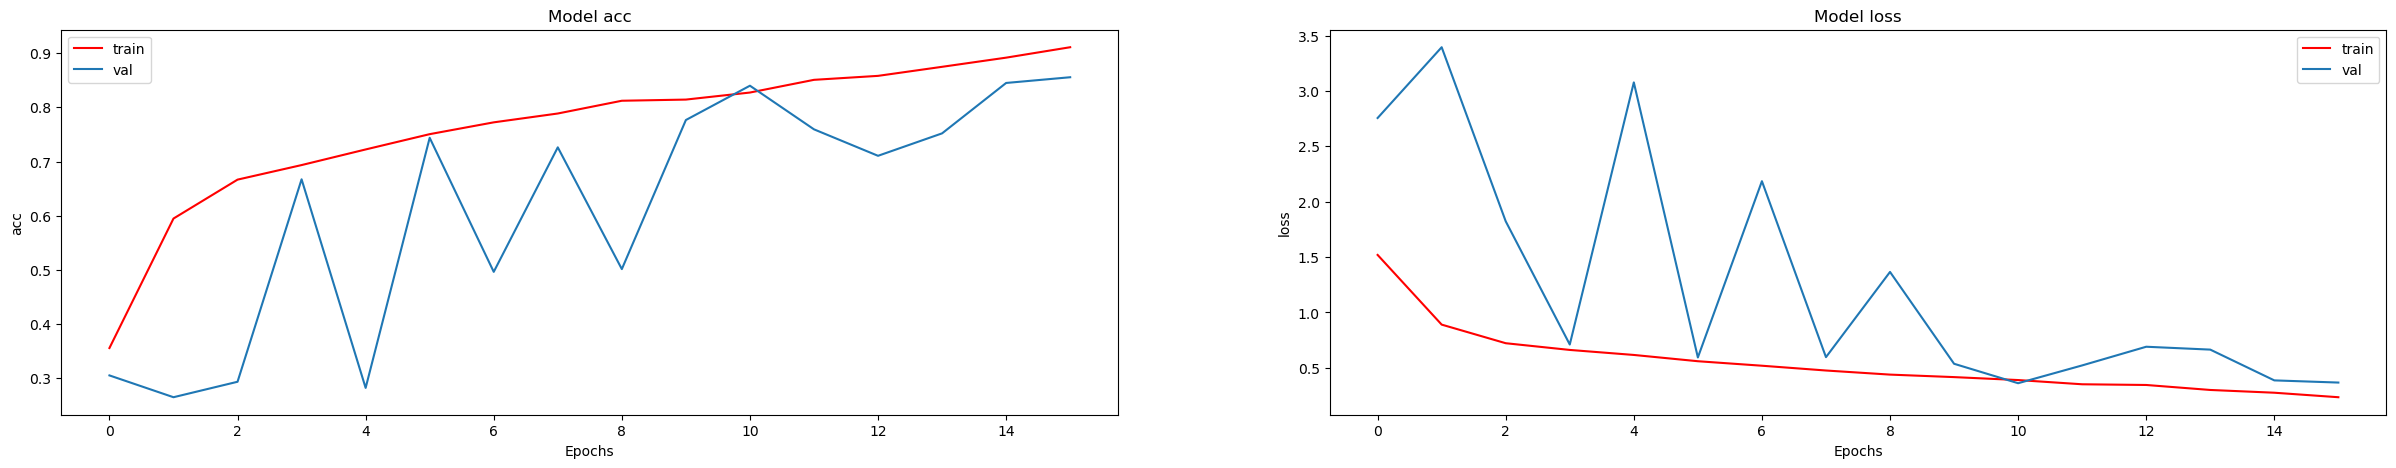

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric],color="r")
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [27]:
test_scores = model.evaluate(test_data, test_labels)
print(test_scores, '\n')
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 26s 318ms/step - loss: 0.3674 - acc: 0.8555 - f1_score: 0.8523
[0.3674080967903137, 0.85546875, array([0.90712744, 1.        , 0.7426009 , 0.7592868 ], dtype=float32)] 

Test Accuracy: 85.55%


In [28]:
test_labels = np.argmax(test_labels, axis=1)
test_pred = model.predict(test_data)
test_pred = np.argmax(test_pred, axis=1)

80/80 [==============================] - 28s 310ms/step


In [29]:
df = pd.DataFrame()
df['Predict'] = test_pred
df['Actual'] = test_labels
df.head()

,Predict,Actual
0,3,3
1,1,1
2,3,2
3,3,3
4,2,2


In [30]:
print(classification_report(test_labels, test_pred, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.84      0.99      0.91       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.91      0.63      0.74       662
ModerateDemented       0.71      0.82      0.76       624

        accuracy                           0.86      2560
       macro avg       0.87      0.86      0.85      2560
    weighted avg       0.87      0.86      0.85      2560



In [31]:
cm = confusion_matrix(test_labels, test_pred)
cm

array([[630,   0,   2,   7],
       [  0, 635,   0,   0],
       [ 44,   0, 414, 204],
       [ 76,   0,  37, 511]], dtype=int64)

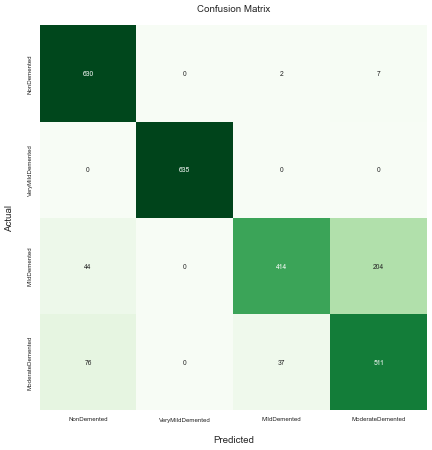

In [32]:
sns.set_style("whitegrid")  # You can choose other styles like "darkgrid", "white", "dark", "ticks", etc.

plt.figure(figsize=(10, 10), dpi=50)
sns.set(font_scale=0.8)

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)

ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(CLASSES)

ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(CLASSES)

ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

In [34]:
model.save('alzheimer_model.keras')
print('model saved')

model saved


In [66]:
new_model = tf.keras.models.load_model('alzheimer_model.keras')
print('model loaded')

model loaded


In [36]:
def _predictImage(image):
    plt.imshow(image)
    plt.show()
    print("Result :", end=" ")
    
    res = new_model.predict(np.array([image]))
    res = np.argmax(res, axis=1)[0]
    return CLASSES[res]

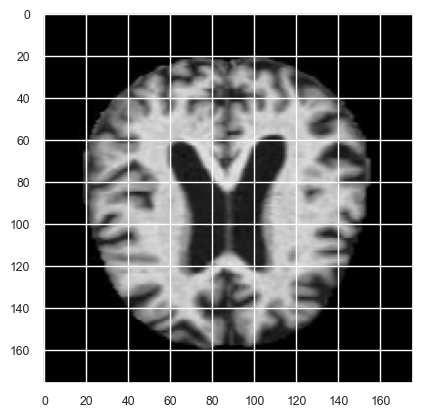

1/1 [==============================] - 0s 497ms/step


('NonDemented', 'NonDemented')

In [37]:
_predictImage(data[0]), CLASSES[np.argmax([data_labels[0]], axis=1)[0]]

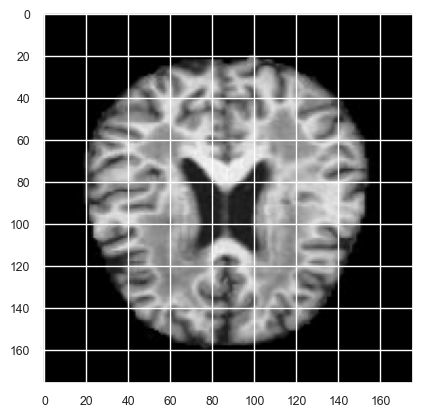

1/1 [==============================] - 0s 47ms/step


('MildDemented', 'MildDemented')

In [38]:
_predictImage(data[1000]), CLASSES[np.argmax([data_labels[1000]], axis=1)[0]]

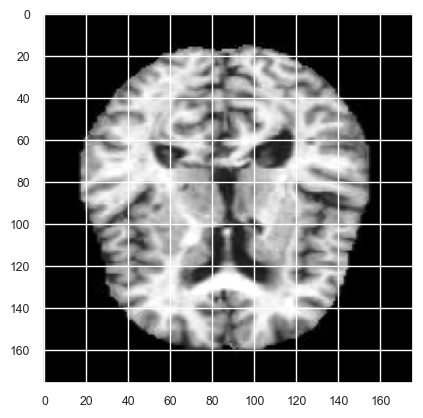

1/1 [==============================] - 0s 35ms/step


('ModerateDemented', 'ModerateDemented')

In [39]:
_predictImage(data[6000]), CLASSES[np.argmax([data_labels[6000]], axis=1)[0]]

## Pretrained Model

In [61]:
img_size = (176, 176)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max',)

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])
# Adamax(learning_rate= 0.001)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 4214788 (16.08 MB)
Non-trainable params: 17697832 (67.51 MB)
_________________________________________________________________


In [65]:
history = model.fit(
    train_data, train_labels,
    validation_data=(test_data, test_labels),
    epochs=15
)

MemoryError: Unable to allocate 3.54 GiB for an array with shape (10240, 176, 176, 3) and data type float32

In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

In [ ]:
test_labels = np.argmax(test_labels, axis=1)
test_pred = model.predict(test_data)
test_pred = np.argmax(test_pred, axis=1)

cm = confusion_matrix(test_labels, test_pred)
print('Confusion Matrix, Without Normalization')
print(cm)
print(classification_report(test_labels, test_pred, target_names= CLASSES))

In [ ]:
model.save('pretrained_alzheimer_model.h5')
print('model saved')
